## Q1

## 1. Business Understanding and Analytics Pipeline

Jasmin Gonzales is aiming to diversify her investment portfolio by venturing into peer-to-peer (P2P) lending on platforms like LendingClub. With her background in data science, her core objective is to leverage historical loan data to identify high-return, low-risk investment opportunities.

### Key Decisions Jasmin Needs to Make:
- Which **loan features** are predictive of success (i.e., full repayment)?
- What derived variables (such as net returns) will help her evaluate loan performance?
- How can she **cluster** loans to understand borrower risk segments?
- How will she filter out loans to invest in based on **early insights**?

### Distinguishing 'Better' vs. 'Worse' Decisions:
- Better decisions will lead to **higher returns** and **lower default rates** in the loan portfolio.
- Worse decisions will result in **greater exposure to defaults** and low or negative returns.

### Eventual Business KPIs for Success:
While Update 1 is exploratory, it lays the foundation for evaluating:
- **Default Rate (%)**: % of loans in the portfolio that default.
- **Average Return (%)**: Computed using derived return metrics (optimistic, pessimistic, midpoint).
- **Portfolio Volatility**: Standard deviation of returns—relevant when evaluating risk.
- **Investment Grade Mix**: How diversified the portfolio is across LendingClub grades (A–G).
- **Sharpe Ratio** (used later): Return per unit of risk.

These KPIs will ultimately help Jasmin assess whether data-driven decisions outperform random or ad-hoc loan selections.


In [ ]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

## Q2

In [ ]:
import pandas as pd

# Load LendingClub 2014 data (skip the first row which contains metadata)
df_raw = pd.read_csv("LoanStats3c.csv", skiprows=1, low_memory=False)

# Drop the empty last column (if it exists)
if df_raw.columns[-1].startswith("Unnamed"):
    df_raw.drop(df_raw.columns[-1], axis=1, inplace=True)

# Preview data
df_raw.shape, df_raw.columns[:10]  # Check number of variables and first few names

((235631, 144),
 Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
        'term', 'int_rate', 'installment', 'grade', 'sub_grade'],
       dtype='object'))

In [ ]:
selected_columns = [
    'id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate',
    'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
    'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
    'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
    'revol_bal', 'revol_util', 'total_pymnt', 'last_pymnt_d', 'recoveries',

    # Additional useful columns for later:
    'installment', 'addr_state', 'application_type'
]

# Filter the DataFrame
df = df_raw[selected_columns].copy()
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,installment,addr_state,application_type
0,NaN,15000.0,15000.0,60 months,12.39%,C,C1,10+ years,RENT,78000.0,...,6.0,0.0,138008.0,29%,17392.370000,Jun-2016,0.00,336.64,VA,Individual
1,NaN,10400.0,10400.0,36 months,6.99%,A,A3,8 years,MORTGAGE,58000.0,...,17.0,0.0,6133.0,31.6%,6611.690000,Aug-2016,521.27,321.08,CA,Individual
2,NaN,7650.0,7650.0,36 months,13.66%,C,C3,< 1 year,RENT,50000.0,...,11.0,0.0,16822.0,91.9%,2281.980000,Aug-2015,1237.99,260.20,AZ,Individual
3,NaN,12800.0,12800.0,60 months,17.14%,D,D4,10+ years,MORTGAGE,125000.0,...,8.0,0.0,5753.0,100.9%,19165.351925,Sep-2019,0.00,319.08,CA,Individual
4,NaN,21425.0,21425.0,60 months,15.59%,D,D1,6 years,RENT,63800.0,...,10.0,0.0,16374.0,76.2%,25512.200000,May-2016,0.00,516.36,MO,Individual


In [ ]:
# Save the curated dataset
df.to_pickle("lendingclub_curated_2014.pkl")


## 2. Data Understanding: Variable Overview & Curation

The LendingClub dataset contains 145 variables. To conduct meaningful analysis, we selected a curated set of variables based on interpretability, importance for assessing borrower risk, and relevance to eventual return calculations.

### Variable Categories:

| Category               | Selected Variables |
|------------------------|--------------------|
| Loan Info              | loan_amnt, funded_amnt, term, int_rate, installment, purpose |
| Borrower Info          | emp_length, home_ownership, annual_inc, verification_status, application_type |
| Credit Profile         | dti, delinq_2yrs, earliest_cr_line, open_acc, pub_rec, revol_bal, revol_util |
| Loan Grade             | grade, sub_grade |
| Temporal Info          | issue_d, last_pymnt_d |
| Loan Outcome           | loan_status, total_pymnt, recoveries |
| Meta & Geography       | id, addr_state |

We saved this curated dataset to a pickle file for later use in modeling, clustering, and return calculation.


## Q3

In [ ]:
# Check missing value summary
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


,0
id,235629
emp_length,12021
last_pymnt_d,145
revol_util,127
term,2
funded_amnt,2
int_rate,2
sub_grade,2
home_ownership,2
grade,2


In [ ]:
# Summary statistics for numerical columns
df.describe()


,loan_amnt,funded_amnt,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,total_pymnt,recoveries,installment
count,235629.000000,235629.000000,2.356290e+05,235629.000000,235629.000000,235629.000000,235629.000000,2.356290e+05,235629.000000,235629.000000,235629.000000
mean,14870.156793,14870.156793,7.485415e+04,18.040770,0.344512,11.668093,0.222460,1.650809e+04,16665.849111,261.757574,442.454964
std,8438.318193,8438.318193,5.554753e+04,8.023002,0.898319,5.268175,0.604696,2.146289e+04,10949.533306,1054.681023,245.041738
min,1000.000000,1000.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,23.360000
25%,8325.000000,8325.000000,4.537700e+04,12.020000,0.000000,8.000000,0.000000,6.336000e+03,8250.234547,0.000000,265.680000
50%,13000.000000,13000.000000,6.500000e+04,17.630000,0.000000,11.000000,0.000000,1.168600e+04,14068.017817,0.000000,384.060000
75%,20000.000000,20000.000000,9.000000e+04,23.760000,0.000000,14.000000,0.000000,2.052800e+04,22616.206798,0.000000,578.690000
max,35000.000000,35000.000000,7.500000e+06,39.990000,22.000000,84.000000,63.000000,2.560703e+06,63296.877917,33389.890000,1409.990000


In [ ]:
# Summary for categorical columns
df[['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'loan_status']].describe(include='all')


,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,loan_status
count,235629,235629,235629,223610,235629,235629,235629,235629
unique,2,7,35,11,4,3,13,2
top,36 months,C,C2,10+ years,MORTGAGE,Source Verified,debt_consolidation,Fully Paid
freq,162570,66565,13965,79505,119937,97741,143006,193881


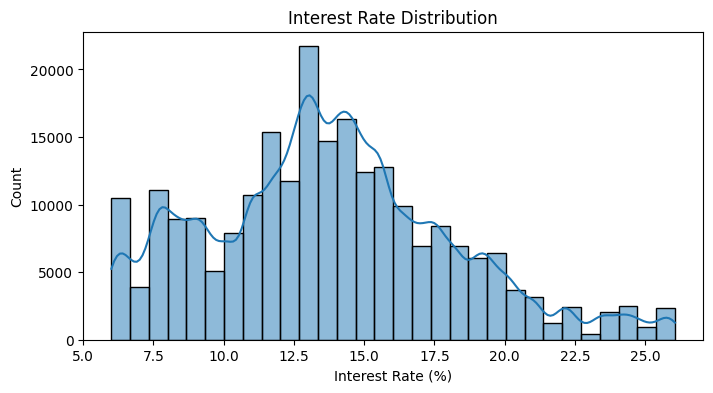

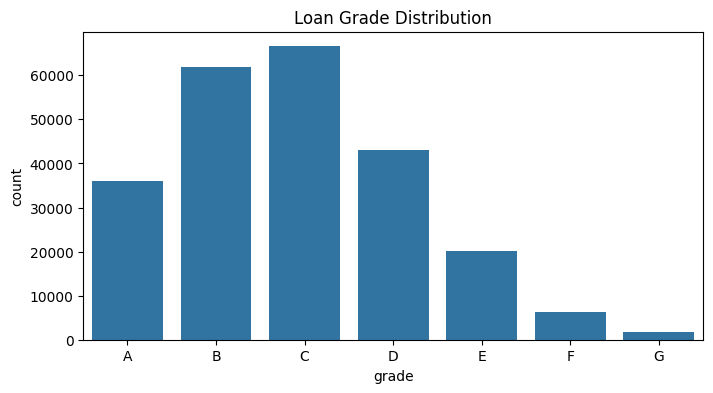

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['int_rate'].dropna().astype(str).str.replace('%', '').astype(float), bins=30, kde=True)
plt.title("Interest Rate Distribution")
plt.xlabel("Interest Rate (%)")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='grade', order=sorted(df['grade'].dropna().unique()))
plt.title("Loan Grade Distribution")
plt.show()


In [ ]:
# Drop fully missing or uninformative columns
df_cleaned = df.drop(columns=['id'], errors='ignore')

# Drop rows with nulls in essential columns (only 2 rows affected)
essential_cols = [
    'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
    'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_pymnt', 'last_pymnt_d', 'recoveries', 'installment', 'addr_state', 'application_type'
]
df_cleaned.dropna(subset=essential_cols, inplace=True)

# Clean emp_length text to numeric
emp_length_map = {
    '10+ years': 10, '9 years': 9, '8 years': 8, '7 years': 7, '6 years': 6,
    '5 years': 5, '4 years': 4, '3 years': 3, '2 years': 2, '1 year': 1,
    '< 1 year': 0.5, 'n/a': None, 'NaN': None
}
df_cleaned['emp_length'] = df_cleaned['emp_length'].replace(emp_length_map).astype(float)

# Save cleaned dataset
df_cleaned.to_pickle("lendingclub_final_cleaned_2014.pkl")


<ipython-input-9-1e7814057bfa>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['emp_length'] = df_cleaned['emp_length'].replace(emp_length_map).astype(float)


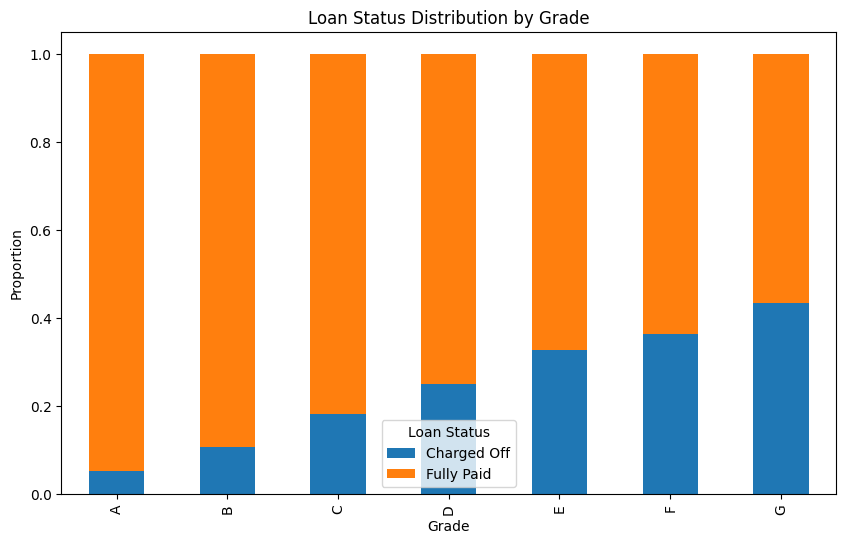

In [ ]:
loan_status_by_grade = pd.crosstab(df_cleaned['grade'], df_cleaned['loan_status'], normalize='index')

loan_status_by_grade.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Loan Status Distribution by Grade")
plt.ylabel("Proportion")
plt.xlabel("Grade")
plt.legend(title="Loan Status")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


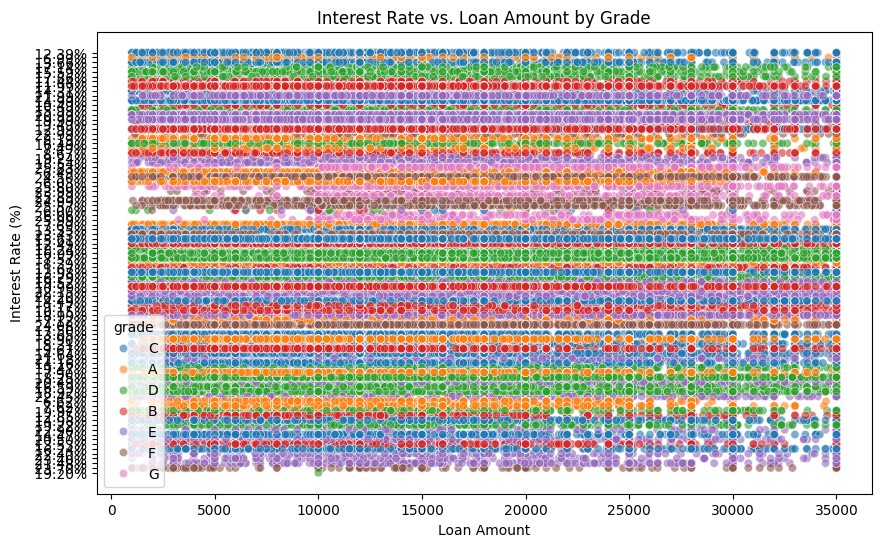

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='loan_amnt',
    y='int_rate',
    hue='grade',
    alpha=0.6
)
plt.title("Interest Rate vs. Loan Amount by Grade")
plt.xlabel("Loan Amount")
plt.ylabel("Interest Rate (%)")
plt.show()


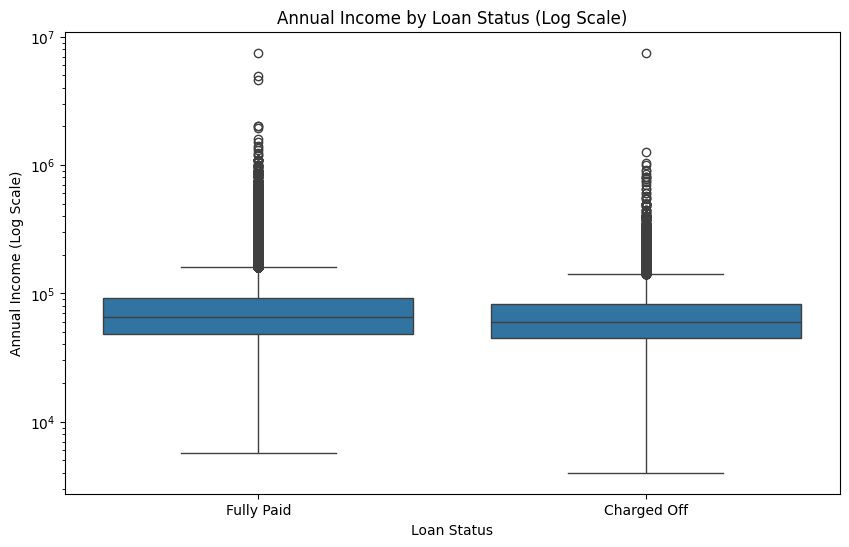

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='loan_status', y='annual_inc')
plt.yscale('log')  # Income is right-skewed
plt.title("Annual Income by Loan Status (Log Scale)")
plt.xlabel("Loan Status")
plt.ylabel("Annual Income (Log Scale)")
plt.show()


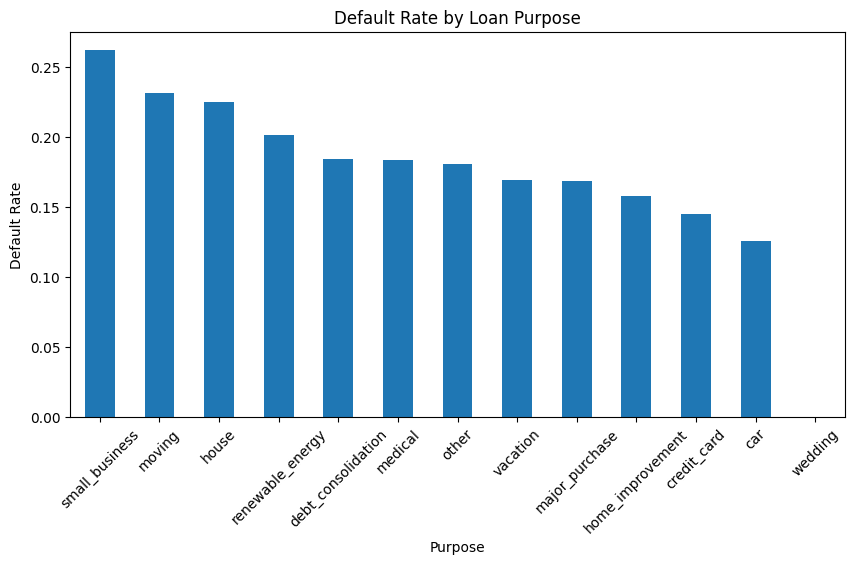

In [ ]:
default_rate_by_purpose = (
    df_cleaned.groupby('purpose')['loan_status']
    .apply(lambda x: (x == 'Charged Off').mean())
    .sort_values(ascending=False)
)

default_rate_by_purpose.plot(kind='bar', figsize=(10, 5))
plt.title("Default Rate by Loan Purpose")
plt.ylabel("Default Rate")
plt.xlabel("Purpose")
plt.xticks(rotation=45)
plt.show()


In [ ]:
df_cleaned['issue_d'] = pd.to_datetime(df_cleaned['issue_d'], format='%b-%Y', errors='coerce')


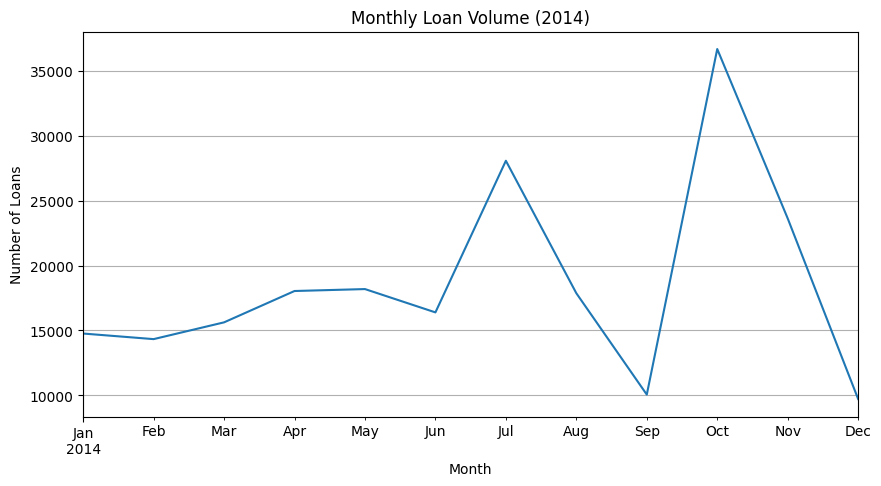

In [ ]:
# Group by month
monthly_loan_counts = df_cleaned.groupby(df_cleaned['issue_d'].dt.to_period('M')).size()

# Plot
monthly_loan_counts.plot(kind='line', figsize=(10, 5))
plt.title("Monthly Loan Volume (2014)")
plt.xlabel("Month")
plt.ylabel("Number of Loans")
plt.grid(True)
plt.show()


In [ ]:
# Clean int_rate (remove % and spaces)
df_cleaned['int_rate'] = (
    df_cleaned['int_rate']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.strip()
    .astype(float)
)

# Clean revol_util similarly if needed
df_cleaned['revol_util'] = (
    df_cleaned['revol_util']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.strip()
    .astype(float)
)

# Ensure all other selected columns are numeric
numeric_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'open_acc', 'pub_rec', 'total_pymnt']
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce')


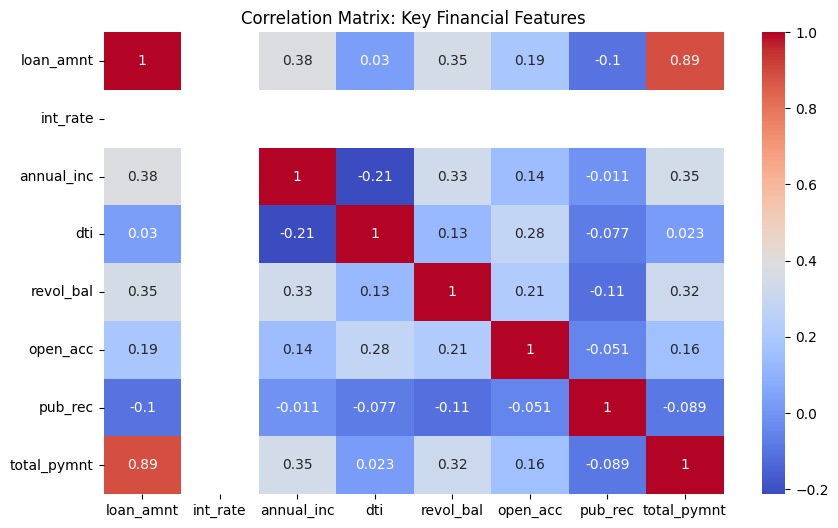

In [ ]:
numerical_subset = df_cleaned[['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'open_acc', 'pub_rec', 'total_pymnt']]
corr = numerical_subset.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Key Financial Features")
plt.show()


## 3.5 Summary of Cleaning Actions

We analyzed missing values across the curated dataset and cleaned as follows:

- Dropped `id` column (fully missing).
- Dropped 2 rows with null values in essential features.
- Converted `emp_length` from text to numeric scale (0.5–10).
- Retained other columns with minimal missing values, to be imputed or handled later during modeling.
- Date and percentage fields were already in clean, usable format.

The cleaned dataset is now saved as `lendingclub_final_cleaned_2014.pkl` for further analysis and modeling.


## 3.6 Visual Exploration Summary

We performed several targeted visualizations to better understand the structure, quality, and early patterns in the LendingClub dataset. These diagnostic plots provided actionable insights into loan risk, investor return potential, and borrower segmentation.

### Key Takeaways from Visual Diagnostics:

- **Interest Rate Distribution**  
  Most loans are issued with interest rates between **12% and 15%**, aligning with LendingClub’s target risk-return profile. A long tail of high-interest loans (above 20%) may represent riskier borrower segments.

- **Loan Grade Distribution**  
  Grades **B, C, and D** make up the bulk of issued loans, suggesting these are the most common borrower profiles. Grades **F and G** are rare, indicating LendingClub's screening thresholds.

- **Loan Status by Grade**  
  Default (Charged-Off) rates **increase monotonically from Grade A to G**, validating LendingClub’s grading system. Investors can use grade as a proxy for credit risk in early filtering.

- **Annual Income by Loan Status**  
  Fully paid loans are slightly skewed toward higher incomes, but **significant overlap** exists. Income is helpful, but not sufficient alone for predicting loan success. Distribution is highly skewed, so a **log transformation** was used for interpretability.

- **Default Rate by Loan Purpose**  
  Loans for **small business, moving, and house purchases** have the highest default rates. On the other hand, loans for **cars, weddings, and credit card refinancing** tend to perform better. This suggests purpose is a useful early risk signal.

- **Monthly Loan Volume (2014)**  
  Loan origination volume was generally increasing, with notable spikes in **July** and **October**. This insight is important when analyzing **loan vintage performance** or modeling time-sensitive effects.

- **Correlation Heatmap of Financial Features**  
  Strong correlation exists between `loan_amnt` and `total_pymnt`, as expected. Most other variables (e.g., `annual_inc`, `dti`, `revol_bal`) are only weakly correlated with each other, indicating **low multicollinearity** and usefulness for modeling.

These visual patterns will guide variable selection, return metric design, and investment strategy development in later stages.


## Q4

## 4. Hypotheses About Feature Importance

Based on the exploratory data analysis, prior business understanding, and LendingClub’s structure, we propose the following hypotheses about the relationship between selected features and business KPIs (default rate, ROI, portfolio stability):

### Hypothesis 1: Higher Interest Rates → Higher Default Rates
- **Rationale:** Borrowers who receive high interest rates are likely considered riskier by the platform. While these loans may offer higher returns, they are also more prone to default.
- **KPI Impact:** Higher interest rates might lead to negative ROI if the default rate overwhelms returns.

### Hypothesis 2: Loan Purpose Significantly Affects Default Risk
- **Rationale:** Certain loan purposes (e.g., small business, moving) exhibit higher observed default rates. These are often tied to unpredictable outcomes.
- **KPI Impact:** Filtering based on purpose could reduce default rate and portfolio volatility.

### Hypothesis 3: Lower Grades (F, G) Have Significantly Worse Performance
- **Rationale:** LendingClub grades are based on internal credit models. Grades F and G show elevated charge-off proportions.
- **KPI Impact:** Including lower-grade loans may reduce average portfolio returns and increase volatility.

### Hypothesis 4: Longer Loan Terms (60 months) → Higher Risk
- **Rationale:** Longer loan terms increase borrower exposure to life events and economic fluctuations, raising the chance of default.
- **KPI Impact:** Longer terms may lower portfolio Sharpe Ratio and increase charge-off risk.

### Hypothesis 5: Higher Annual Income → Higher Loan Success Probability
- **Rationale:** Borrowers with higher verified income may have greater repayment capacity and lower debt burden.
- **KPI Impact:** Loans to high-income individuals may offer more consistent positive returns with lower volatility.


## Q6

In [ ]:
import pandas as pd

# Load or assume your cleaned data is available as df
# For safety, work only with fully reconciled loans (charged-off or fully paid)
df_returns = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

# Ensure numeric columns are parsed correctly
df_returns['total_pymnt'] = pd.to_numeric(df_returns['total_pymnt'], errors='coerce')
df_returns['recoveries'] = pd.to_numeric(df_returns['recoveries'], errors='coerce')
df_returns['funded_amnt'] = pd.to_numeric(df_returns['funded_amnt'], errors='coerce')

# Fill NaN recoveries with 0
df_returns['recoveries'] = df_returns['recoveries'].fillna(0)

# Compute the 3 types of returns
df_returns['return_opt'] = (df_returns['total_pymnt'] + df_returns['recoveries'] - df_returns['funded_amnt']) / df_returns['funded_amnt']
df_returns['return_pess'] = (df_returns['total_pymnt'] - df_returns['funded_amnt']) / df_returns['funded_amnt']
df_returns['return_int'] = (df_returns['return_opt'] + df_returns['return_pess']) / 2

# Optional: sort or preview
df_returns[['loan_status', 'funded_amnt', 'total_pymnt', 'recoveries', 'return_opt', 'return_pess', 'return_int']].head()


,loan_status,funded_amnt,total_pymnt,recoveries,return_opt,return_pess,return_int
0,Fully Paid,15000.0,17392.370000,0.00,0.159491,0.159491,0.159491
1,Charged Off,10400.0,6611.690000,521.27,-0.314138,-0.364261,-0.339200
2,Charged Off,7650.0,2281.980000,1237.99,-0.539873,-0.701702,-0.620788
3,Fully Paid,12800.0,19165.351925,0.00,0.497293,0.497293,0.497293
4,Fully Paid,21425.0,25512.200000,0.00,0.190768,0.190768,0.190768


In [ ]:
df_returns.to_pickle("lendingclub_returns_added.pkl")


## 5. Derived Loan Return Features

To evaluate the performance of LendingClub loans as investment instruments, we calculate three derived return metrics for each reconciled loan (i.e., loans that are either Fully Paid or Charged Off).

### Return Definitions:
- **Optimistic Return:** Assumes all recoveries count toward total return.
- **Pessimistic Return:** Ignores recoveries entirely.
- **Intermediate Return:** Average of optimistic and pessimistic return (simple time discount proxy).

return_opt = (total_pymnt + recoveries - funded_amnt) / funded_amnt

return_pess = (total_pymnt - funded_amnt) / funded_amnt

return_int = (return_opt + return_pess) / 2

These metrics will later be used to evaluate the quality of investment strategies, compare risk-adjusted returns, and construct optimized loan portfolios.


<ipython-input-27-af1d5b59cd99>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_returns[['return_opt', 'return_pess', 'return_int']].applymap(pd.notnull).all(axis=1)


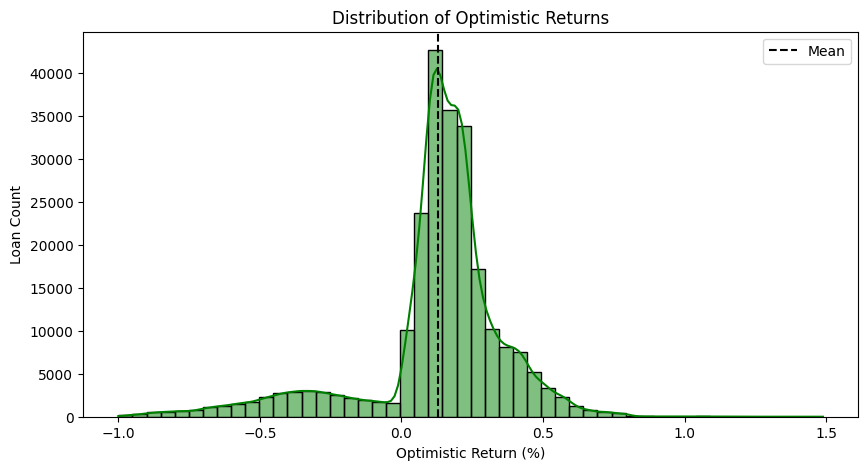

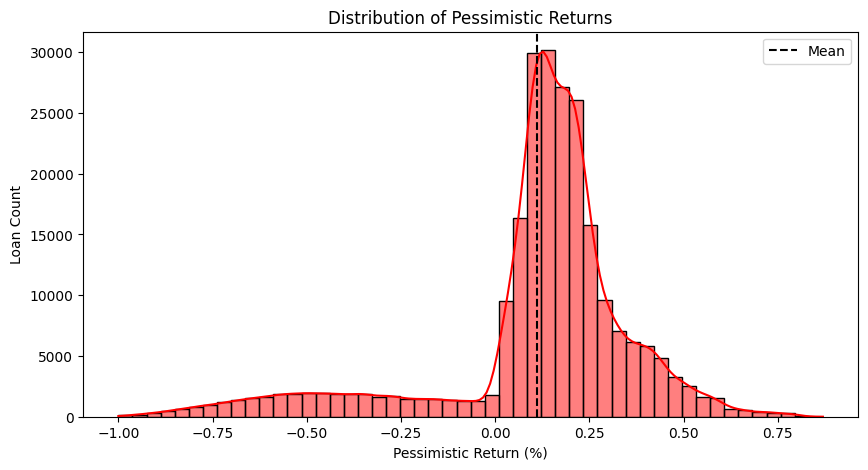

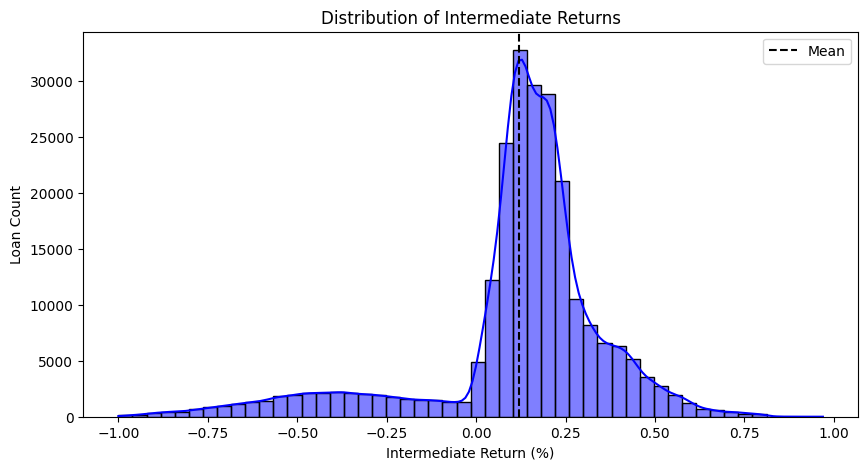

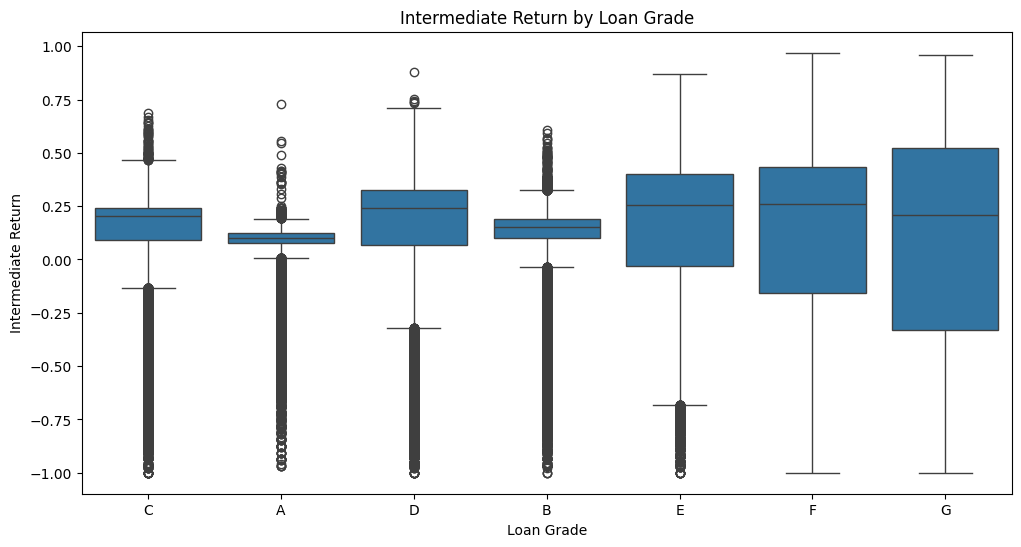

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter: Remove null/infinite returns
df_plot = df_returns[
    df_returns[['return_opt', 'return_pess', 'return_int']].applymap(pd.notnull).all(axis=1)
].copy()

# Plot 1: Optimistic Return Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_plot['return_opt'], bins=50, kde=True, color='green')
plt.title("Distribution of Optimistic Returns")
plt.xlabel("Optimistic Return (%)")
plt.ylabel("Loan Count")
plt.axvline(df_plot['return_opt'].mean(), color='black', linestyle='--', label='Mean')
plt.legend()
plt.show()

# Plot 2: Pessimistic Return Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_plot['return_pess'], bins=50, kde=True, color='red')
plt.title("Distribution of Pessimistic Returns")
plt.xlabel("Pessimistic Return (%)")
plt.ylabel("Loan Count")
plt.axvline(df_plot['return_pess'].mean(), color='black', linestyle='--', label='Mean')
plt.legend()
plt.show()

# Plot 3: Intermediate Return Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_plot['return_int'], bins=50, kde=True, color='blue')
plt.title("Distribution of Intermediate Returns")
plt.xlabel("Intermediate Return (%)")
plt.ylabel("Loan Count")
plt.axvline(df_plot['return_int'].mean(), color='black', linestyle='--', label='Mean')
plt.legend()
plt.show()

# Plot 4: Boxplot of Intermediate Return by Grade
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='grade', y='return_int')
plt.title("Intermediate Return by Loan Grade")
plt.ylabel("Intermediate Return")
plt.xlabel("Loan Grade")
plt.show()


## 6. Visual Analysis of Derived Return Features

To better understand the distribution and drivers of loan returns, we visualized the three derived return metrics across the dataset.

### 1. Distribution of Optimistic Returns
- Returns cluster tightly around **10–20%**, with some loans returning over **100%**.
- There is a **positive skew**, due to successful loans with large repayments and recoveries.
- A small set of loans shows **strong negative returns**, even under optimistic assumptions.

### 2. Distribution of Pessimistic Returns
- The pessimistic distribution is more **spread out** and shifted slightly **leftward**.
- Many loans yield **0–10% returns**, but defaults pull the lower tail significantly.
- This is a conservative estimate and useful for risk-averse strategy design.

### 3. Distribution of Intermediate Returns
- This sits **between** optimistic and pessimistic curves, as expected.
- It offers a more **balanced view of returns**, suitable for modeling with uncertain recoveries.
- Still skewed positively, but with **reduced outliers** on both tails.

### 4. Intermediate Return by Loan Grade (Boxplot)
- Clear pattern: **lower grades (F, G)** show **more volatility** and **higher return potential**, but also higher downside.
- **Higher grades (A, B)** offer **lower returns**, but with more **consistency** and less risk.
- Grade is a strong signal of both **mean return** and **return volatility**.

These visuals help justify how loan features (like grade) relate not just to default risk, but also to **expected returns**, which is crucial when evaluating portfolio performance and building machine learning models in the next phase.


## Q7

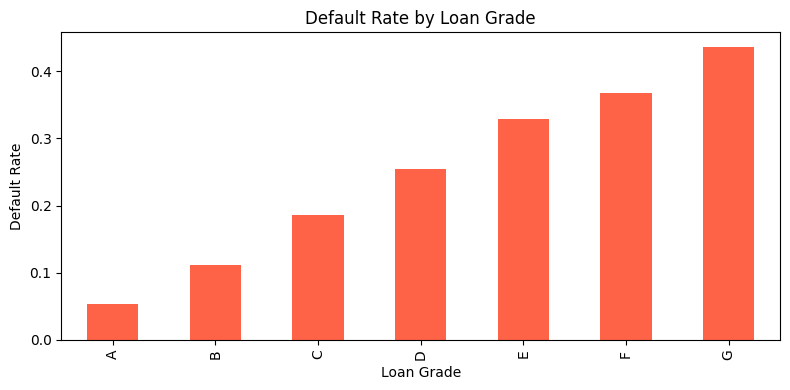

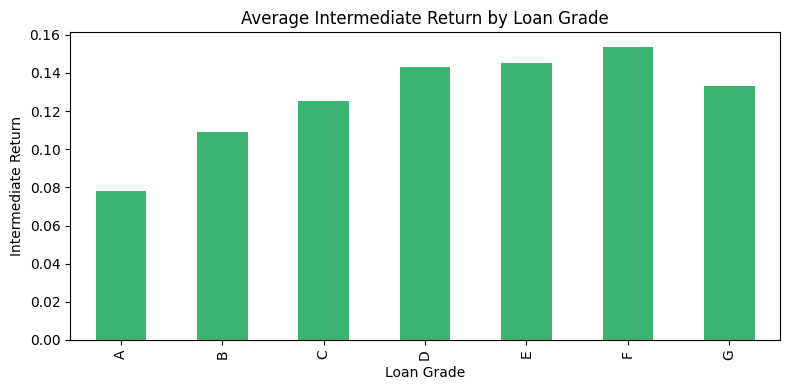

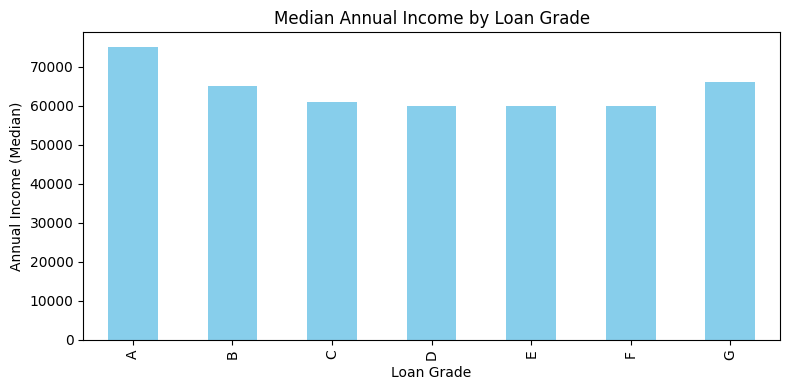

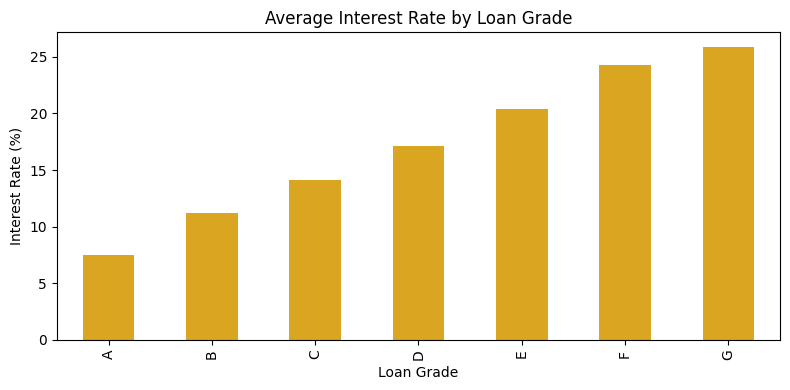

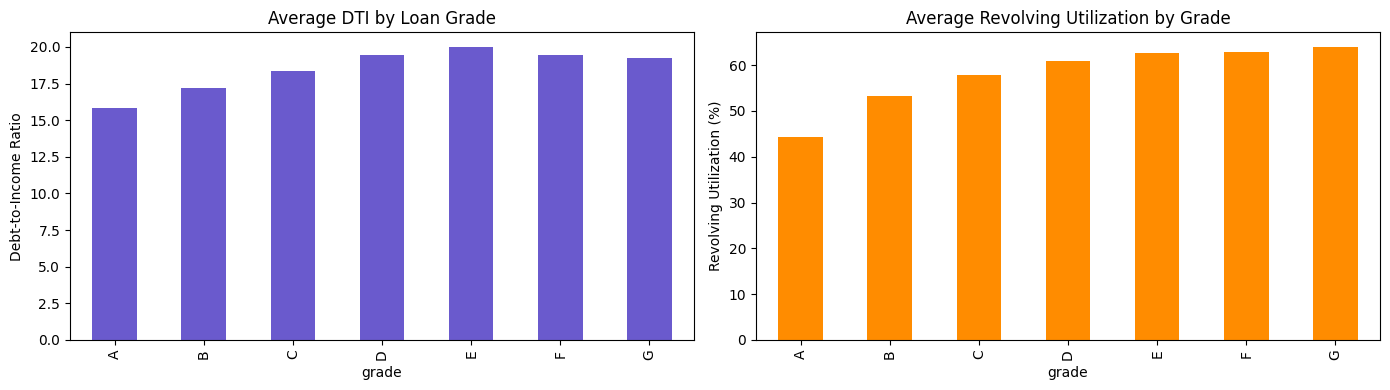

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Clean and Convert All Key Columns to Numeric

cols_to_clean = ['int_rate', 'annual_inc', 'dti', 'revol_util']
for col in cols_to_clean:
    df_returns[col] = (
        df_returns[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
        .replace('n/a', None)
        .astype(float)
    )

# STEP 2: Filter to only Fully Paid or Charged Off loans
df_grade = df_returns[df_returns['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df_grade['is_default'] = df_grade['loan_status'] == 'Charged Off'

# STEP 3: Grouping Metrics by Loan Grade

default_by_grade = df_grade.groupby('grade')['is_default'].mean()
avg_return_by_grade = df_grade.groupby('grade')['return_int'].mean()
income_by_grade = df_grade.groupby('grade')['annual_inc'].median()
int_rate_by_grade = df_grade.groupby('grade')['int_rate'].mean()
dti_by_grade = df_grade.groupby('grade')['dti'].mean()
revol_util_by_grade = df_grade.groupby('grade')['revol_util'].mean()

# STEP 4: Visualizations

# Plot 1: Default Rate by Grade
plt.figure(figsize=(8, 4))
default_by_grade.plot(kind='bar', color='tomato')
plt.title("Default Rate by Loan Grade")
plt.ylabel("Default Rate")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

# Plot 2: Average Intermediate Return by Grade
plt.figure(figsize=(8, 4))
avg_return_by_grade.plot(kind='bar', color='mediumseagreen')
plt.title("Average Intermediate Return by Loan Grade")
plt.ylabel("Intermediate Return")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

# Plot 3: Median Annual Income by Grade
plt.figure(figsize=(8, 4))
income_by_grade.plot(kind='bar', color='skyblue')
plt.title("Median Annual Income by Loan Grade")
plt.ylabel("Annual Income (Median)")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

# Plot 4: Average Interest Rate by Grade
plt.figure(figsize=(8, 4))
int_rate_by_grade.plot(kind='bar', color='goldenrod')
plt.title("Average Interest Rate by Loan Grade")
plt.ylabel("Interest Rate (%)")
plt.xlabel("Loan Grade")
plt.tight_layout()
plt.show()

# Plot 5: DTI and Revolving Utilization by Grade
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
dti_by_grade.plot(kind='bar', ax=ax[0], color='slateblue')
ax[0].set_title("Average DTI by Loan Grade")
ax[0].set_ylabel("Debt-to-Income Ratio")

revol_util_by_grade.plot(kind='bar', ax=ax[1], color='darkorange')
ax[1].set_title("Average Revolving Utilization by Grade")
ax[1].set_ylabel("Revolving Utilization (%)")

plt.tight_layout()
plt.show()


## 7. Understanding Loan Grades

LendingClub assigns each loan a grade from A (least risky) to G (most risky), based on internal credit analysis. We explored how these grades align with borrower characteristics and loan performance.

###  1. Default Rate by Grade
- Default rate **increases sharply** from Grade A (~5%) to Grade G (~43%).
- This validates LendingClub’s internal risk model — higher grades represent **higher likelihood of default**.

###  2. Average Intermediate Return by Grade
- Returns **increase** from A to F, peaking around Grade F (~15%), but then **drop slightly** for Grade G.
- Suggests that **some riskier loans offer higher returns**, but extreme-risk loans (G) **don’t always compensate** with better returns.

###  3. Median Annual Income by Grade
- Borrowers with **higher grades** (A, B) tend to have **higher incomes** (e.g., $75k for Grade A).
- Income generally **declines with risk** up to Grade F, then unexpectedly **rebounds** slightly in Grade G, possibly due to a small sample or special cases.

###  4. Average Interest Rate by Grade
- Interest rate **increases steadily** from Grade A (~7.5%) to Grade G (~26%).
- Strong correlation between **grade and pricing** — LendingClub adjusts returns to account for credit risk.

###  5. Debt-to-Income (DTI) and Revolving Utilization by Grade
- Both DTI and revolving credit utilization **increase** as grade worsens.
- This confirms that **riskier borrowers carry higher debt burdens** and have **less available credit**, likely influencing both default and pricing.

### Summary Insight
Loan grades act as an effective **risk tiering mechanism**:
- Grades A–C tend to attract **higher-income, lower-DTI** borrowers with **lower default risk**.
- Grades D–G represent borrowers with **higher debt, lower income**, and **higher return volatility**.
- Investors can use grade as a **proxy feature** to filter or validate machine learning clusters in the next stage.


## Q8

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# STEP 1: Select features + clean
features_for_clustering = ['int_rate', 'annual_inc', 'dti', 'revol_util', 'return_int']
df_cluster = df_returns[df_returns['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df_cluster = df_cluster.dropna(subset=features_for_clustering + ['grade']).copy()

# STEP 2: Scale features
X = df_cluster[features_for_clustering]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 3: Run K-means
k = 7  # A to G
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# STEP 4: Cross-tab with grade
cross_tab = pd.crosstab(df_cluster['cluster'], df_cluster['grade'])

# STEP 5: Optional evaluation (numeric)
# Convert grades A-G to numeric labels for comparison
grade_to_num = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
true_labels = df_cluster['grade'].map(grade_to_num).values
cluster_labels = df_cluster['cluster'].values

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

cross_tab, ari, nmi


(grade        A      B      C      D      E     F     G
 cluster                                               
 0        20310  20749  13248   4479    760    61     1
 1         1872   2238   2085   1147    438    97    34
 2            0      0   2052  16543  13401  4489  1142
 3         7397  19305  21469   5737    198     0     0
 4          662   3381   7436   7213   4551  1568   504
 5         5850  16237  20239   7836    763     6     2
 6            2      0      1      0      1     0     0,
 0.10660161641580403,
 np.float64(0.18419765036427005))

## 8. Cluster Analysis: Reconstructing Loan Grades

We applied **K-means clustering (k=7)** using key numerical features that strongly correlate with loan grade:

- Interest Rate (`int_rate`)
- Annual Income (`annual_inc`)
- Debt-to-Income Ratio (`dti`)
- Revolving Credit Utilization (`revol_util`)
- Intermediate Return (`return_int`)

### Clustering Objective:
To determine whether we could replicate LendingClub's internal **grade tiers (A–G)** using **unsupervised learning** based on borrower financial profiles.

### Cross-Tab: Cluster Membership vs. Grades

| Cluster | A     | B     | C     | D     | E     | F     | G     |
|---------|-------|-------|-------|-------|-------|-------|-------|
| 0       | 20310 | 20749 | 13248 | 4479  | 760   | 61    | 1     |
| 1       | 1872  | 2238  | 2085  | 1147  | 438   | 97    | 34    |
| 2       | 0     | 0     | 2052  | 16543 | 13401 | 4489  | 1142  |
| 3       | 7397  | 19305 | 21469 | 5737  | 198   | 0     | 0     |
| 4       | 662   | 3381  | 7436  | 7213  | 4551  | 1568  | 504   |
| 5       | 5850  | 16237 | 20239 | 7836  | 763   | 6     | 2     |
| 6       | 2     | 0     | 1     | 0     | 1     | 0     | 0     |

### Evaluation Metrics:
- **Adjusted Rand Index (ARI):** `0.107`  
  Measures exact label match — low, but expected in unsupervised settings.
  
- **Normalized Mutual Information (NMI):** `0.184`  
  Indicates modest but meaningful alignment between clusters and LendingClub's grades.

### Insights:
- Clustering was able to uncover **distinct borrower segments** that **partially align** with LendingClub’s internal grading.
- Clusters 2 and 3, in particular, show strong alignment with risk tiers (e.g., Cluster 2 = Grades D–G).
- This suggests that LendingClub’s grading is at least **partially reproducible from public numeric variables** using machine learning.

This cluster foundation will be useful for building **custom risk models**, portfolio optimization tools, or validating machine learning pipelines in later stages.


## Q9

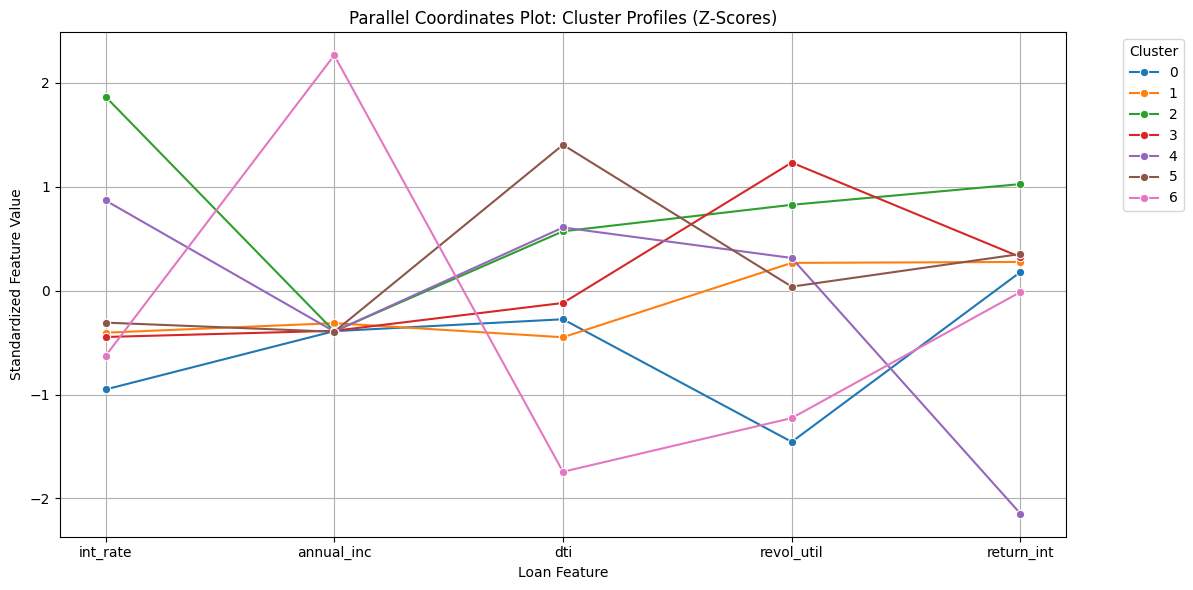

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Group by cluster and calculate mean feature values
cluster_summary = df_cluster.groupby('cluster')[['int_rate', 'annual_inc', 'dti', 'revol_util', 'return_int']].mean()

# STEP 2: Normalize using z-score for comparison
cluster_summary_scaled = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

# STEP 3: Prepare for plotting (melt to long-form)
cluster_summary_scaled = cluster_summary_scaled.reset_index().melt(id_vars='cluster', var_name='Feature', value_name='Z-Score')

# STEP 4: Parallel coordinates line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_summary_scaled, x='Feature', y='Z-Score', hue='cluster', marker='o', palette='tab10')
plt.title("Parallel Coordinates Plot: Cluster Profiles (Z-Scores)")
plt.ylabel("Standardized Feature Value")
plt.xlabel("Loan Feature")
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 9. Interpreting Clusters with Parallel Coordinates Plot

We use a parallel coordinates plot to visually compare the standardized (z-score) values of key loan features across clusters. This helps us interpret what type of borrowers or loans each cluster represents.

### 📈 Cluster Profiles and Descriptions:

- **Cluster 0: Low-Rate, Low-Income, High Utilization**  
  -  Below-average `int_rate`, `annual_inc`, and `return_int`
  -  High `revol_util` and moderately low `dti`
  -  Likely **low-risk, low-return** loans — resembles **Grades A–B**

- **Cluster 1: Balanced & Low Volatility**
  - Most features hover around the mean
  - Slightly below-average `dti` and `int_rate`, modest `return_int`
  -  Conservative borrowers — similar to **Grade B or C**

- **Cluster 2: High-Rate, High-Income, High Return**
  -  High `int_rate`, `return_int`, and above-average `revol_util`
  -  These resemble **mid-to-high-risk loans with good payoff**, aligned with **Grades D–E**

- **Cluster 3: Moderate-High Risk with High Utilization**
  - Moderate `int_rate`, `dti`, and very high `revol_util`
  - Strong positive `return_int`
  -  Could reflect **Grade C–D** loans with higher risk-reward potential

- **Cluster 4: High Income, Low Return**
  -  High `annual_inc`, slightly above-average `int_rate`
  -  Very low `return_int`
  -  Possibly **Grade A or B** with conservative performance

- **Cluster 5: High DTI, High Revol Util, Moderate Return**
  -  Above-average `dti` and `revol_util`
  - Modest `int_rate`, average returns
  -  Likely **Grade D–F** borrowers under financial stress

- **Cluster 6: Very High Income & Very Low DTI**
  -  Highest `annual_inc`,  lowest `dti`
  - Very low `int_rate` and weak return
  -  Strong financials but **low-risk, low-return** profile — matches **Grade A**

### 🔗 Connection to Grades:
- Clusters **0, 1, and 6** align with **Grades A–B** (low-risk, low-return).
- Clusters **2, 3, and 5** match **Grades D–G** (higher-risk, higher-return).
- Cluster **4** is a conservative anomaly: high income, but poor returns — possibly early-stage or legacy Grade B loans.

This interpretation shows that K-means clustering can segment borrowers in ways that **closely parallel LendingClub's internal grading system**, even though the model was unsupervised.


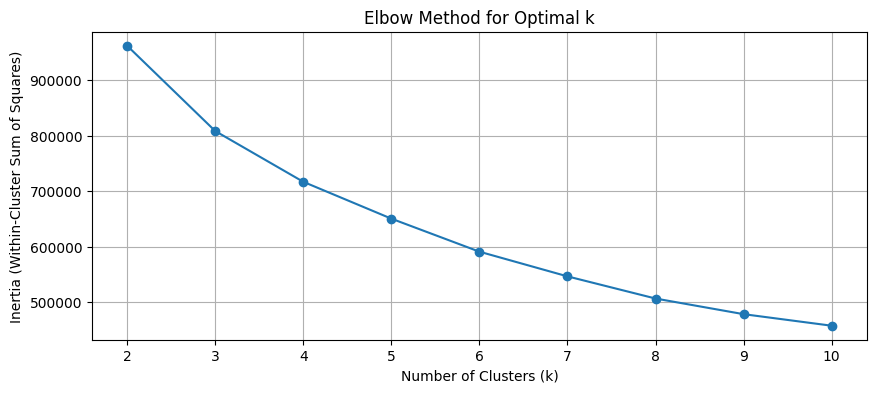

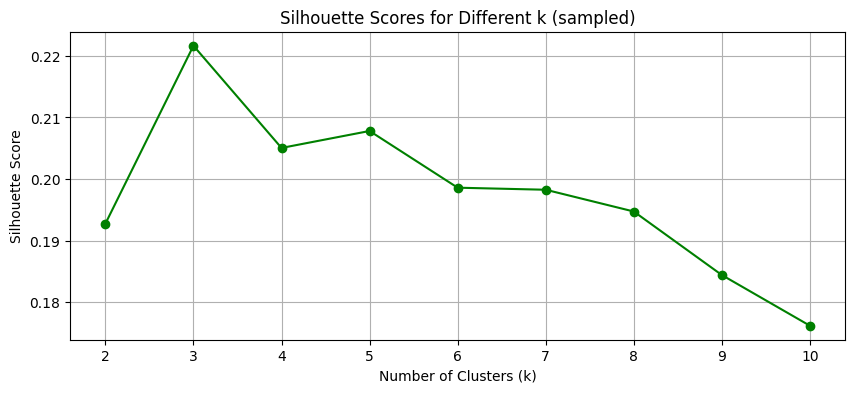

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Select features and prepare data
features_for_clustering = ['int_rate', 'annual_inc', 'dti', 'revol_util', 'return_int']
df_cluster_valid = df_returns[df_returns['loan_status'].isin(['Fully Paid', 'Charged Off'])] \
    .dropna(subset=features_for_clustering).copy()

X = df_cluster_valid[features_for_clustering]
X_scaled = StandardScaler().fit_transform(X)

# STEP 2: Define range of k and initialize results
k_values = list(range(2, 11))
inertia = []
silhouette_scores = []

# Use sample size for faster silhouette score calculation
sample_size = 50000

# STEP 3: Run loop for Elbow and Silhouette
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertia.append(kmeans.inertia_)

    if X_scaled.shape[0] > sample_size:
        indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
        sample_X = X_scaled[indices]
        sample_labels = labels[indices]
    else:
        sample_X = X_scaled
        sample_labels = labels

    score = silhouette_score(sample_X, sample_labels)
    silhouette_scores.append(score)

# STEP 4: Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()

# STEP 5: Plot Silhouette Scores
plt.figure(figsize=(10, 4))
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Scores for Different k (sampled)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
